# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **<br>
The aim of our algorithm is to predict, for each student, if he is going to fail his graduation (discrete output), which means if he belongs to the category of students who graduate (class 1), or (actually XOR) to the category of students who do not graduate(class 2).<br>
Our supervised learning problem is thus a **classification** problem.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


In [2]:
student_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [3]:
from __future__ import division
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = len(student_data.columns) - 1

# TODO: Calculate passing students
n_passed = len(student_data[student_data['passed'] == 'yes'])

# TODO: Calculate failing students
n_failed = len(student_data[student_data['passed'] == 'no'])

# TODO: Calculate graduation rate
grad_rate = n_passed/n_students*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [6]:
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1.0,0.0,1.0,0.0,18,0.0,1.0,1.0,0.0,1.0,...,1,0,0,4,3,4,1,1,3,6
1,1.0,0.0,1.0,0.0,17,0.0,1.0,1.0,0.0,0.0,...,1,1,0,5,3,3,1,1,3,4
2,1.0,0.0,1.0,0.0,15,0.0,1.0,0.0,1.0,0.0,...,1,1,0,4,3,2,2,3,3,10
3,1.0,0.0,1.0,0.0,15,0.0,1.0,1.0,0.0,0.0,...,1,1,1,3,2,2,1,1,5,2
4,1.0,0.0,1.0,0.0,16,0.0,1.0,1.0,0.0,0.0,...,1,0,0,4,3,2,1,2,5,4


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [7]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=num_train, test_size=num_test, random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **<br>
To choose three models, we must consider the two constraints of the problem :<br>
-it must have good performances<br>
-it must have a small computation cost<br>
<br>
We will study the following algorithms : Gaussian Naive Bayes, SVM and Random forest.<br><br>
Naive Bayes have the advantage of being simple. Even if the dummy variables are not really independent thus contradicting the "naive" independence assumption, we can still expect good performances. Moreover, it will converge quickly and is computationally cheap.<br>
Naive Bayes thus seems to be a good candidate for our problem, as we expect good performances and small computation cost. 
<br>
Naive Bayes classifiers are often used in document classification by analyzing the text inside (ex: spam vs not spam emails) (https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification)
<br><br>
SVM has a high accuracy and is resistant to overfitting. It is effective in our high-dimensions case.  We may need a bit of tuning but by choosing the right hyperparameters (kernel...) we should be able to have nice performance. It may be a bit computationally expensive however.<br><br>
We can also expect a high accuracy from Random Forests as it is more resistant to overfitting than classical decision trees. The training may be slow and thus computionally expensive but predicting is fast and scalable. We will need less tuning than SVM.<br>
SVM thus seems to be a good candidate as we expect good performances and acceptable computation costs as there are not so much data to be computed (we are only talking about a few hundreds of students and the algorithms won't have to be runned so many times).<br>
SVM often has scientific applications : it has been used to classify proteins (https://en.wikipedia.org/wiki/Support_vector_machine#Applications)
<br><br>
Random Forest is a good algorithm to use for complex classification classes. It has a very good accuracy and it scales nicely on big databases. It has no problem dealing with a lot of features so our dummy variables won't have a bad impact. Even if it sometimes tends to overfit on noisy data, it is worth giving a try.
<br>
Random Forest thus seems to be a good candidate as we expect good performances and acceptable computation costs. 
<br>
The following scientific study used random forest. Its explicit title is "Application of random forest algorithm for studying habitat selection of colonial herons and egrets in human-influenced landscapes" (http://link.springer.com/article/10.1007/s11284-014-1147-0)
<br><br>
All three algorithms respect the performance and computation cost constraints. I also chose them as they are very different approaches and was curious about how they would behave and 

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [8]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    #print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    #print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    #print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    #print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    #print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
# TODO: Import the three supervised learning models from sklearn
#Gaussian Naive Bayes, SVM (SVC) and Random forest
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = SVC(random_state=42)
clf_C = RandomForestClassifier(random_state=42)

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for model in [clf_A, clf_B, clf_C]:
    for X_train_sample, y_train_sample in [(X_train_100, y_train_100), (X_train_200, y_train_200), (X_train_300, y_train_300)]:
        train_predict(model, X_train_sample, y_train_sample, X_test, y_test)


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - GaussianNB**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |      0.0034             |       0.0008           |    0.8467        |   0.8029        |
| 200               |        0.0020           |             0.0007     |    0.8406        |      0.7244     |
| 300               |     0.0025              |               0.0007   |       0.8038     |    0.7634       |

** Classifer 2 - SVM (SVC)**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |    0.0041               |  0.0018                |  0.8777          |  0.7746         |
| 200               |   0.0074                |                 0.0030 |           0.8679 |       0.7815    |
| 300               |   0.0163                |   0.0040               |  0.8761          |   0.7838        |

** Classifer 3 - Random Forests**  

| Training Set Size | Training Time           | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |  0.0288                 | 0.0018                 |   0.9844         | 0.7153          |
| 200               |      0.0301             | 0.0020                 | 0.9964           | 0.7857          |
| 300               |          0.0324         | 0.0019                 | 0.9951           | 0.8092          |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **<br>
Let's first compare the different models' test performances depending on the training set size. As three training set sizes is a bit short to make general statements, let's get get more data.

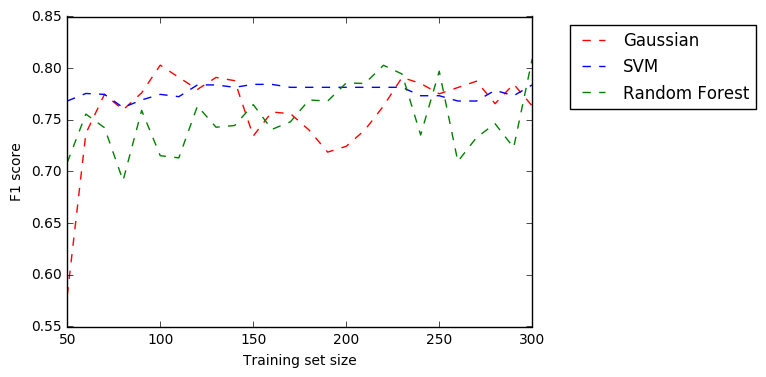

In [10]:
import matplotlib.pyplot as plt

def get_F1(clf, training_set_size):
        X_train_sample = X_train[:training_set_size]
        y_train_sample = y_train[:training_set_size]
        train_classifier(clf, X_train_sample, y_train_sample)
        return predict_labels(clf, X_test, y_test)

clf_A_2 = GaussianNB()
clf_B_2 = SVC(random_state=42)
clf_C_2 = RandomForestClassifier(random_state=42)

f1_list_all = []
for clf in [clf_A_2, clf_B_2, clf_C_2]:
    f1_list = []
    for training_set_size in range(50,301,10):
        f1_list.append(get_F1(clf, training_set_size))
    f1_list_all.append(f1_list)
plt.plot(range(50,301,10), f1_list_all[0], 'r--', label='Gaussian')
plt.plot(range(50,301,10), f1_list_all[1], 'b--', label='SVM')
plt.plot(range(50,301,10), f1_list_all[2], 'g--', label='Random Forest')
plt.xlabel('Training set size')
plt.ylabel('F1 score')
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show()


In [13]:
print 'Average F1 score of the Gaussian model : {:.4f}'.format(np.mean(f1_list_all[0]))
print 'Average F1 score of the SVM (SVC) model : {:.4f}'.format(np.mean(f1_list_all[1]))
print 'Average F1 score of the Random Forests model : {:.4f}'.format(np.mean(f1_list_all[2]))

Average F1 score of the Gaussian model : 0.7595
Average F1 score of the SVM (SVC) model : 0.7770
Average F1 score of the Random Forests model : 0.7519


It looks like it has been useful to get more data. Indeed, F1 score is quite noisy and 3 values for each was not enough to make good assumptions.<br>
Our graph tells us that choosing the SVM model is a 'safe' choice, as it is much less noisy than the other ones. Additionally, its average F1 is the best one of our three models.<br>
**Concerning performance, our best model is SVM.**<br><br>
In terms of **training and prediction time**, our best choice would be to take the **GaussianNB** then SVM and finally RandomForests. However, the time difference are really low and would not have a big impact on the computation price even at large scale. It is is more important to choose our model in terms of performance.<br><br>
**We will then choose the SVM model as the best one for the following steps.**

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **<br>
Let's imagine a flat planet with only dogs and cats. After 10,000 years of intense war between the two peoples, they finally understand that no one will ever beat the other one and commonly decide to make peace.<br>
As they are very tired both dogs and cats fell asleep at the same time and none can move anymore.<br>
However, given all the loss on both sides, they really don't like each other and want a **boundary to separate the two species**.<br><br>
<u>On this planet, cats are in the north and dogs are in the south.</u>
<br>
The King of the dogs and the King in the North, which are communicating via smartphones to instaure peace, cannot agree on how to split the earth into two territories. Thus, they decide to use the help of a neutral foreigner to solve their problem.<br>
As you are a galactic traveler passing by, you get contacted.<br>
However, **you can only make laser boundaries which are lines or planes (or hyperplanes)**.<br>
Additionally, your laser boundaries make some noise and the closer a dog or a cat is from the boundary the less it can sleep, and you should not favorite the cat people or the dog people. **So you'd better have the boundary equally distant to the two groups.**<br><br>
This is a flat planet and as cats are in the north and dogs are in the south, you can easily install a laser boundary that have cats on one side and dogs on the other ones. The first part of the contract is completed (separate them), now you have to deal with having your boundary equally distant to the two groups. So you walk to find the closest cats and dogs to the line and you adjust the line so that it get farer from them (so that they can sleep). And you do it again and until **you find the best line to separate the two peoples.** You have just finished to **train** an algorithm called Support Vector Machines and this line is the result of your work.<br><br>
Happy of it, you fall asleep. But in the night, you hear lots of screams from different places. You first are scared (because the night is dark and full of terrors) but you then decide to see what is going on. So you go to each place where something is crying (obviously a dog or a cat but you cannot recognize it as you lost a bit of your audition in an accident. Damned asteroids ! Stupid spaceship !). But at each of these places, you cannot see anything (it's the night) and as no cat or dog was there during the day, you have no idea if it is a dog or a cat. You have to feed each one of the crying creatures and fast as it is getting cold (winter is coming) and you don't want it to die.<br>Luckily you have dog food and cat food on you, but you must not give the wrong food or it will die as well. So you use the only thing that can help you : the shining laser boundary which tells you if you are on the cats side or the dogs side.<br>
For each crying creature, you check on which side you are and you accordingly give to the creature the dog or the cat food.
<br>
On the morning, you are being told that these were traps made by both kings and cat to see if your line is able to determine if something is a cat or a dog. And as the kings knew if each one was a cat or a dog, your boundary is given a **test score**. You are surprised, but happy that you got a good score (at least you know that you can accurately predict wether a thing is a cat or a dog thanks to the boundary you made).
<br><br><br>
As both kings were happy of your work, you obtain a certification and update you LinkedIn. Thanks to that, you are called for another very similar mission on another planet.<br><br>
It is exactly the same problem (the dogs-cats war happens in the entire universe), however this time it happens than the dogs' kingdom was under siege and there are cats all around them, as in the following B plot. <u>You cannot use a simple straight line anymore to separate them</u>. However, you have in your pocket The Hitchhiker's Guide to the Galaxy to help you.<br><br>
Remember that your laser boundaries can also be plans. So you follow your guide and put a flying balloon on each dogs and cats, which now all levitate at different altitude. With an appropriate mathemagic formula for your hydrogen balloons, levitating dogs and cats are now separable by a laser plan boundary. Just like on the other planet, you know equally maximize the distance between the boundary and the two groups and you obtain the **best plane to separate them**. Look on the 3D plot red cats and blue dogs separated by your green laser plane boundary.<br>
Now you explode all the balloons, and at the same time, while dogs and cats are falling back on their planet, you fold your plane so that no dog or cat get hurt and when they all are back on their feets (mostly cats, obviously), you take the intersection of your folded boundary with the earth and have the new best separation between dogs and cats, as you can see from above the planet on the last plot, blue dogs and red cats are equally distant from the separating boundary. Your job is done and prepare some dog and cat food to get ready to being tested by the kings as last time.<br><br><br>
With all you success, you now create a The Intergalactic Boundary Services Corporation, the most successful company ever. You receive Nobel Prize for stopping all wars in the universe. As this peace lasts, trade between dogs and cats begins and, possessing all borders in the universe, a few tax borders everywhere and you can fairly buy a pretty good new spaceship.<br>
Thanks SVM !

<img src="https://udacity-github-sync-content.s3.amazonaws.com/_imgs/8650/1461641606/SVM.png">

<img src="https://udacity-github-sync-content.s3.amazonaws.com/_imgs/372/1474214009/data_2d_to_3d_hyperplane.png">

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [16]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# TODO: Initialize the classifier
clf = SVC(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Tuned model has a training F1 score of 0.8761.
Tuned model has a testing F1 score of 0.7838.


We have found the same scores as with our untuned model. Let's try to do the same gridsearch but without the default 'rbf' kernel to see if the score changes.

In [17]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer

# TODO: Create the parameters list you wish to tune
parameters = {
    'C': [1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'sigmoid']
}

# TODO: Initialize the classifier
clf = SVC(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Second tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Second tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Second tuned model has a training F1 score of 0.8119.
Second tuned model has a testing F1 score of 0.7742.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **<br>
Tuned model has a training F1 score of 0.8761.<br>
Tuned model has a testing F1 score of 0.7838.<br>
We actually find the exact same values as we had found in with the untuned model. That is probably due to the fact that the default parameters give the best model among all the parameters possibilities of our grid. Indeed, our second tuned model which cannot be using the default kernel 'rbf' gives us a lower f1 score.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.